# 論文読解入門

以下の、CNNを使った物体検出（Object Detection）の代表的な研究を読む。

[8]Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99

https://arxiv.org/pdf/1506.01497.pdf

## 前提知識（箇条書き）

- 物体検出の際など評価指標としては、Average Precision(AP)が良く使用される

## 用語

 - 画像識別（classification)、物体検出（detection）、意味分割（segmentation）
 - regional proposal、RoI(Region of Interest) ：領域候補
 - region proposal function(ROIs)
 - SelectiveSearch、Edge Boxes：領域候補アルゴリズム
 - warping：regionをCNNに合わせるために変形すること
 - VGG16（Simonyan and Zisserman model）、ZF（Zeiler and Fergus model）、convnet、Overfeat：CNNのネットワークの種類
 - IoU(intersection over union)：物体認識の分野で領域の一致具合を評価する手法
 
 - コンペ、データセット
   - ImageNet：物体名が付与された大規模画像データセット。WordNetの概念辞書の用語を使用
   - PASCAL VOC：2005〜2012頃の有名なコンペ
   - ILSVRC(ImageNet Large Scale Visual Recognition Challenge) ：ImageNetを題材とした画像認識のコンペ（2010~）

## (1) 物体検出の分野にはどういった手法が存在したか。

- RCNN
  - R-CNN (Regions with Convolutional Neural Networks) は、四角形の領域候補を畳み込みニューラル ネットワークの特徴と組み合わせる、 2 段階検出アルゴリズム。第 1 段階では、オブジェクトを含んでいる可能性のあるイメージ内の領域のサブセット（領域候補）を特定し、第 2 段階では、候補からCNN特徴量を抽出し、各領域に含まれるオブジェクトを分類する。入力画像は固定サイズである必要があり、そのため、cropingやwarpingの調整処理が必要。
  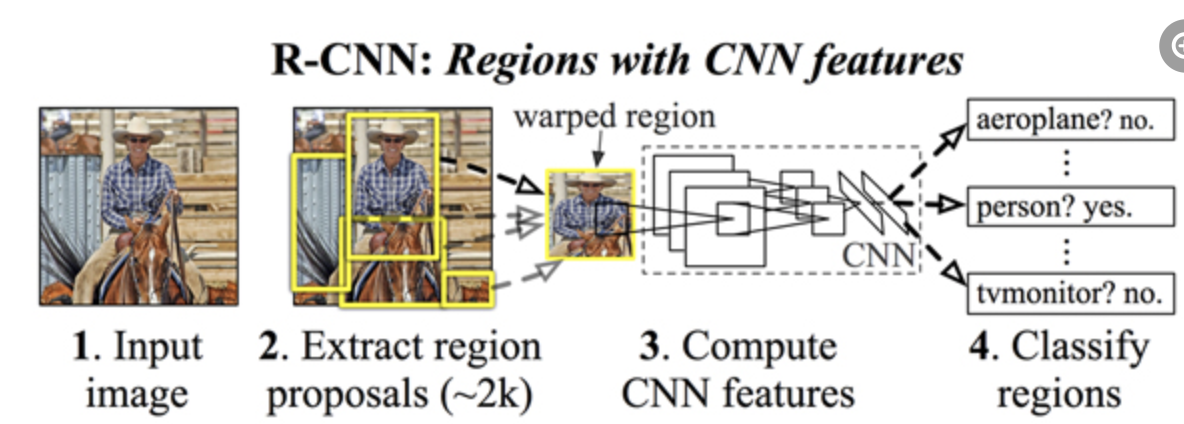
  上図：引用[4]
  
  - 論文：https://arxiv.org/pdf/1311.2524.pdf


- SPPnet
  - 従来の技術であるRCNNは、SelectiveSearchなどで得た候補領域の1つ1つをクロッピング、ワーピングの処理を施してCNNの入力に渡すが、クロッピング、ワーピングの処理は望ましくない幾何学的な歪みをもたらす可能性があること。また、SelectiveSearchで得る約2000件ほどの候補領域1つ1つをCNNにかけるのでとても時間がかかること。こうした問題に対し、畳み込みの処理を画像全体から一度だけ行うことで計算時間の短縮を行なった手法。
  - 最大の特徴はSPP(Spatial Pyramid Pooling)と呼ばれるプーリングを実装することで、入力の画像サイズに関わらず固定長の出力を得ることができるので入力が固定ではなく可変サイズに変更できること。SPP層では、畳み込み層からの特徴マップを それぞれ 16x16, 4x4, 1x1 のウィンドウでmaxプーリングを行い、結果をreshapeして固定長の出力にして全結合層へ渡す。

  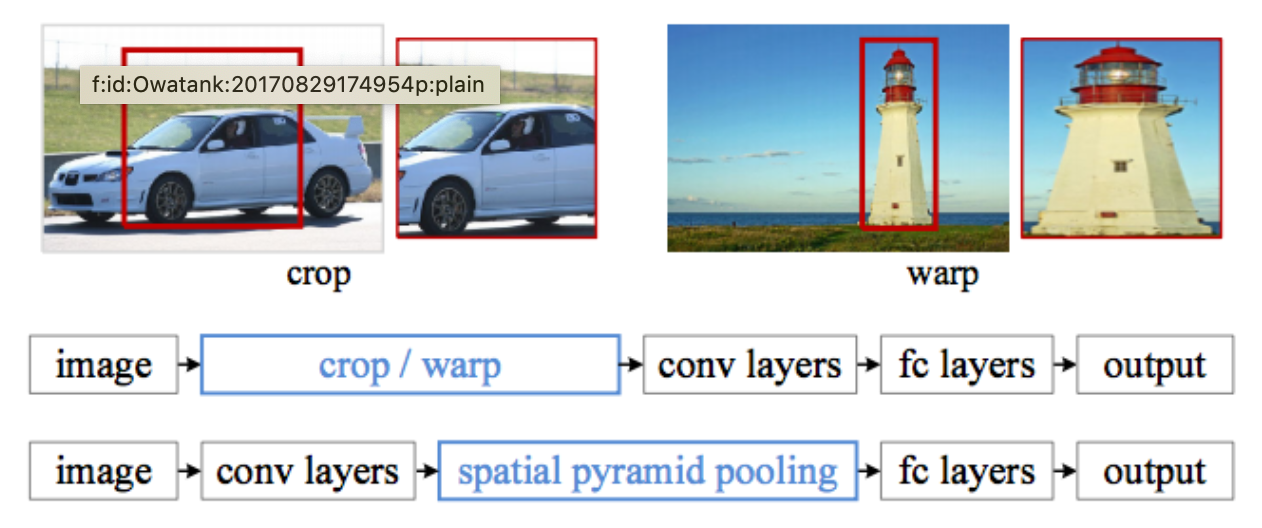
  RCNNとSPPnetの違い（引用：[2]）
  
  - 論文：https://arxiv.org/pdf/1406.4729.pdf


- Fast-RCNN
  
  - ある程度畳み込み処理を行ったfeature mapから、region proposalにあたる部分領域をうまく「固定サイズのfeature map」として抽出するRoI Poolingを行うことで、畳込み処理を共通化し、高速化を実現。
  - 推定誤差は、物体の種別の推定誤差と、物体の外接矩形の位置・サイズの推定誤差の2つだが、multi-task lossを導入することで、1回の学習で各ステージを同時に学習できるようになった。
  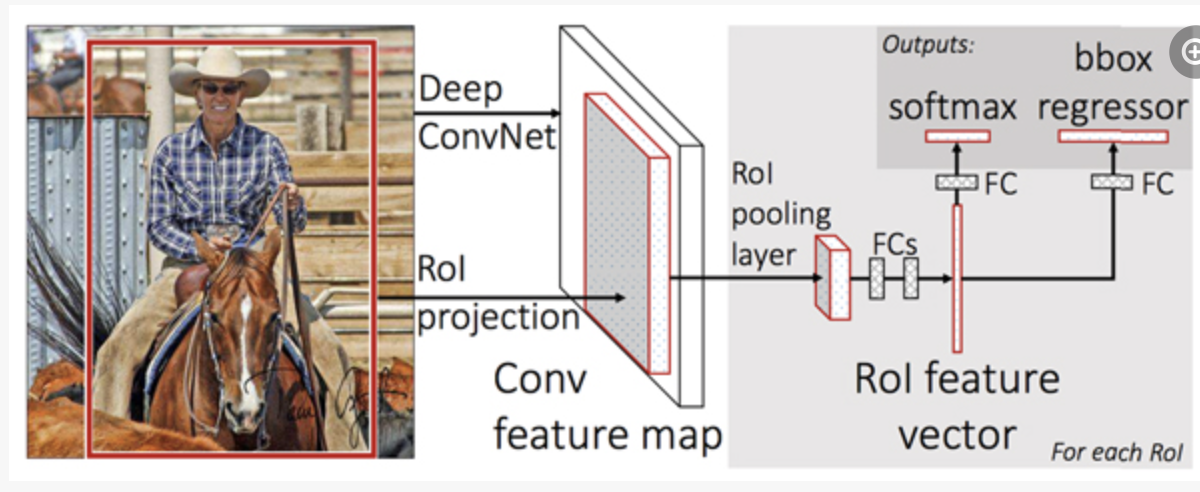
  （論文内から引用）
  
  - 論文：https://arxiv.org/pdf/1504.08083.pdf
  
  
## 論文の着眼点

 - Fast R-CNNの領域ベース検知で使用されているような、特徴量マップが、領域候補の検出にも使用できることに気づいた。
 > Our observation is that the convolutional feature maps used by region-based detectors, like Fast RCNN,can also be used for generating region proposals.  (p.1 右下段)
 
 - そこで、筆者たちは、特徴量マップの直後に追加の畳み込み層を僅かに組み込むことによって、RPN（Region proposal network）と呼ばれる独自のネットワークを構築した。これにより、RoIプーリングを外部的に組み込むことなく、物体候補ごとに固定サイズのFeature mapを生成することに成功した。
 

## (2) Fasterとあるが、どういった仕組みで高速化したのか。
 1. これまで、物体検出とクラスタリングは別々のネットワークで学習させていたが、RPNとFast R-CNNに同一のCon層を利用する事で、速度を向上させた。（p.5 右下段）
   - RPNとFast R-CNNを完全に一体として学習するためには、RoI warpingレイヤーが必要となる
 2. Anchorの参照システムがあることで、多数のフィルタを生成することなく、SPPの固定長の出力を得ることができる。
 3. RPNのtranslation-invariant property（不変量特性）により、RoIプーリングに渡すモデルサイズをかなり軽減することができる。（p.4 左下段）
   - 不変量特性とは、Anchor Boxが各スライド領域に対して一貫した重みやパラメータを保持することで、全結合層に渡す次元が少なくて済む事を言う。MultiBoxでは、K-meansによってAnchorを算出し、各Anchorごとにパラメータを独立して保持するので、Anchor数だけ次元が必要となる。
 
 
## (3) One-Stageの手法とTwo-Stageの手法はどう違うのか。
以下、論文p.10より

- One-Stage
  - 代表的なモデルとしてOverFeatがあるが、ピラミッドモデルの中で単一のアスペクト比のスライディングウィンドウを使用する方法では、抽出された特徴量は、位置の特定と物体のカテゴライズの両方に同時に使用される。
  
- Two-Stage
  - これに対し、Faster R- CNNでは、特徴量は特定サイズのスライディングウィンドウと、アンカーと紐づいた多様なサイズの領域予測から生み出される。こちらもスライディングウィンドウを使用しているが、Faster R-CNNでは第一段では領域提案のみが行われる。物体のカテゴライズについては、第二段階において、領域の性質が付与された特徴量が使用されることになる。このことにより、領域の特徴をより正確に掴むことができる。

## (4) RPN(Region proposal network)とは何か。
 - RPNは、入力された特徴量マップをもとに、物体の領域と、スコアを算出することができる、いわばそれだけで小さなCNNのようなネットワークである。（p.1 右下段）
 - RPNは、特徴量マップに対し、nxn（論文ではn=3）のスライドウィンドウを生成し、そこから算出された特徴量を下位次元も含めてbox-regression layer（reg）とbox-classification layer（cls）に渡す。（p.3 右中段）
 - RPNは、「Anchor」と呼ばれる中心座標を利用することで、１箇所のスライディングウィンドウに対し、多様なサイズ・アスペクト比の領域候補を紐付け、予測することができる。（p.2 左上段) 
 - RPNは、Fast R-CNNにどこに注目するべきかを示唆する領域候補を提示する。（p3. 右上段）
 
 
## (5) RoIプーリングとは何か。
＜Fast R-CNNの論文より＞
 - 物体候補領域(RoI)をその特徴量空間に投影し、投影されたRoIの中でMax Pooling処理を行うことで物体候補ごとに固定サイズのFeature mapを生成する層
 > The RoI pooling layer uses max pooling to convert the features inside any valid region of interest into a small fea- ture map with a fixed spatial extent of H × W (e.g., 7 × 7), where H and W are layer hyper-parameters that are inde- pendent of any particular RoI. （p.2 左下段）
 - 各RoIは、固定サイズの特徴マップにプールされ、さらに全結合層に渡されることで、特徴量ベクトルになる。特徴量ベクトルは、その後、Softmax処理と、Bounding Box回帰処理の２つに分けて処理される。

## (6) Anchorのサイズはどうするのが適切か。

- 学習を走らせてみた結果、loss関数の観点からアスペクト比は1:1以上が良いとなった
> we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1.　(P.5 右中段)
- スコアリングの結果、3 scale 3 aspect ratioとするのが良い。（p.9 table8）

 
## (7) 何というデータセットを使い、先行研究に比べどういった指標値が得られているか。

- PASCAL VOC 2007（→P7〜）
  - 従来モデルに比べて2~4%のスコア改善
- MS COCO
  - 従来モデルに比べて7%~13%のスコア改善（Table11）


## (8) （アドバンス課題）Faster R-CNNよりも新しい物体検出の論文では、Faster R-CNNがどう引用されているか。

## 図表引用、参考サイト

1. https://jp.mathworks.com/help/vision/ug/faster-r-cnn-basics.html
2. http://owatank.hatenablog.com/entry/2017/08/29/182549
3. https://qiita.com/yu4u/items/5cbe9db166a5d72f9eb8
4. https://news.mynavi.jp/article/cv_future-54/